In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
import os
import glob

import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
from torchvision import transforms, models
from torchvision.utils import make_grid
from torch.utils.data import Dataset, DataLoader


In [3]:
base_path = "/kaggle/input/facades"

img_height = 256
img_width  = 256

transform = transforms.Compose([
    transforms.Resize((img_height, img_width), interpolation=Image.BICUBIC),
    transforms.ToTensor(),                     # converts to [0, 1]
    transforms.Normalize((0.5, 0.5, 0.5),       # normalize to [-1, +1]
                         (0.5, 0.5, 0.5))
])

class FacadesDataset(Dataset):
    def __init__(self, root_dir, mode="train", transform=None):
        super().__init__()
        self.transform = transform
        self.mode = mode.lower()
        # Build full paths to <mode>A and <mode>B
        self.dir_A = os.path.join(root_dir, f"{self.mode}A")
        self.dir_B = os.path.join(root_dir, f"{self.mode}B")
        # Collect and sort all filenames in each
        self.files_A = sorted(glob.glob(os.path.join(self.dir_A, "*.*")))
        self.files_B = sorted(glob.glob(os.path.join(self.dir_B, "*.*")))
        assert len(self.files_A) == len(self.files_B), \
               f"Number of A images ({len(self.files_A)}) != B images ({len(self.files_B)})"

    def __len__(self):
        return len(self.files_A)

    def __getitem__(self, idx):
        # Load A (label map) and B (real facade) by index
        path_A = self.files_A[idx]
        path_B = self.files_B[idx]
        img_A = Image.open(path_A).convert("RGB")
        img_B = Image.open(path_B).convert("RGB")

        # Apply transforms (resize, to tensor, normalize)
        if self.transform:
            img_A = self.transform(img_A)
            img_B = self.transform(img_B)

        return {"A": img_A, "B": img_B}

# 4. Quick sanity check (run only if this cell is executed directly)
if __name__ == "__main__":
    ds_train = FacadesDataset(root_dir=base_path, mode="train", transform=transform)
    print(f"Found {len(ds_train)} training pairs.")
    sample = ds_train[0]
    print("Sample['A'].shape:", sample["A"].shape)  # e.g. [3, 256, 256]
    print("Sample['B'].shape:", sample["B"].shape)  # e.g. [3, 256, 256]

    loader = DataLoader(ds_train, batch_size=4, shuffle=True)
    batch = next(iter(loader))
    print("Batch A:", batch["A"].shape)  # [4, 3, 256, 256]
    print("Batch B:", batch["B"].shape)  # [4, 3, 256, 256]


Found 400 training pairs.
Sample['A'].shape: torch.Size([3, 256, 256])
Sample['B'].shape: torch.Size([3, 256, 256])
Batch A: torch.Size([4, 3, 256, 256])
Batch B: torch.Size([4, 3, 256, 256])


In [4]:
#generator
# Building UNET


class DownSample(nn.Module):
    def __init__(self, Input_Channels, Output_Channels):
        super(DownSample, self).__init__()
        # nn.Conv2d(in_channel, out_channel, kernel, stride, padding)
        self.model = nn.Sequential(
                     nn.Conv2d(Input_Channels, Output_Channels, 4, 2, 1, bias=False),
                     nn.LeakyReLU(0.2)
                     )

    def forward(self, x):
        down = self.model(x)
        return down


class Upsample(nn.Module):
    def __init__(self, Input_Channels, Output_Channels):
        super(Upsample, self).__init__()

        self.model = nn.Sequential(
                     nn.ConvTranspose2d(Input_Channels, Output_Channels, 4, 2, 1, bias=False),
                     nn.InstanceNorm2d(Output_Channels),
                     nn.ReLU(inplace=True),)

    def forward(self, x, skip_input):
        x = self.model(x)
        x = torch.cat((x, skip_input), 1)
        return x


class Generator(nn.Module):
    def __init__(self, in_channels=3, out_channels=3):
        super(Generator, self).__init__()

        self.down1 = DownSample(in_channels, 64)
        self.down2 = DownSample(64, 128)
        self.down3 = DownSample(128, 256)
        self.down4 = DownSample(256, 512)
        self.down5 = DownSample(512, 512)
        self.down6 = DownSample(512, 512)
        self.down7 = DownSample(512, 512)
        self.down8 = DownSample(512, 512)

        self.up1 = Upsample(512, 512)
        self.up2 = Upsample(1024, 512)
        self.up3 = Upsample(1024, 512)
        self.up4 = Upsample(1024, 512)
        self.up5 = Upsample(1024, 256)
        self.up6 = Upsample(512, 128)
        self.up7 = Upsample(256, 64)

        self.final = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.ZeroPad2d((1, 0, 1, 0)),
            nn.Conv2d(128, 3, 4, padding=1), # out_channels
            nn.Tanh(),
        )

    def forward(self, x):
        # U-Net generator with skip connections from encoder to decoder

        d1 = self.down1(x)
        d2 = self.down2(d1)
        d3 = self.down3(d2)
        d4 = self.down4(d3)
        d5 = self.down5(d4)
        d6 = self.down6(d5)
        d7 = self.down7(d6)
        d8 = self.down8(d7)
        u1 = self.up1(d8, d7)
        u2 = self.up2(u1, d6)
        u3 = self.up3(u2, d5)
        u4 = self.up4(u3, d4)
        u5 = self.up5(u4, d3)
        u6 = self.up6(u5, d2)
        u7 = self.up7(u6, d1)
        u8 = self.final(u7)
        return u8


In [5]:
#discriminator - patchgan


# Building Discriminator

class Discriminator(nn.Module):
    def __init__(self, in_channels=3,):
        super(Discriminator, self).__init__()


        self.model = nn.Sequential(
                     nn.Conv2d(6, 64, 4, 2, 1, bias=False),
                     nn.LeakyReLU(0.2, inplace=True),

                     nn.Conv2d(64, 128, 4, 2, 1, bias=False),
                     nn.LeakyReLU(0.2, inplace=True),

                     nn.Conv2d(128, 256, 4, 2, 1, bias=False),
                     nn.LeakyReLU(0.2, inplace=True),

                     nn.Conv2d(256, 512, 4, 2, 1, bias=False),
                     nn.LeakyReLU(0.2, inplace=True),

                     nn.ZeroPad2d((1, 0, 1, 0)),
                     nn.Conv2d(512, 1, 4, padding=1, bias=False)

                     )


    def forward(self, img_A, img_B):
        # Here we are concatenating the images on their channels
        img_input = torch.cat((img_A, img_B), 1)
        return self.model(img_input)

In [6]:
image = torch.rand((1,3,256,256))
out_channels = 3
generator = Generator()
k = generator(image)
print(k.shape)

torch.Size([1, 3, 256, 256])


In [7]:
image1 = torch.rand((1,3,256,256))
image2 = torch.rand((1,3,256,256))

out_channels = 3
discriminator = Discriminator()
k = discriminator(image1,image2)
print(k.shape)

torch.Size([1, 1, 16, 16])


In [8]:
# ─── Cell: Create DataLoaders for Facades (Train + Test Only) ─────────────────

# Use the previously defined FacadesDataset and transform
dataset_train = FacadesDataset(root_dir=base_path, mode="train", transform=transform)
dataset_test  = FacadesDataset(root_dir=base_path, mode="test",  transform=transform)

dataloader_train = torch.utils.data.DataLoader(
    dataset_train, batch_size=24, shuffle=True,  num_workers=2
)
dataloader_test = torch.utils.data.DataLoader(
    dataset_test,  batch_size=24, shuffle=False, num_workers=2
)

# Quick sanity print
print(f"Train batches: {len(dataloader_train)}, Test batches: {len(dataloader_test)}")


Train batches: 17, Test batches: 5


In [9]:
print(len(dataset_train))
print(len(dataset_test))

400
106


In [10]:
batch = next(iter(dataloader_train))
images = batch["B"] # label‐map side
targets = batch["A"]  # real‐photo side

print(images.shape)   # e.g. torch.Size([24, 3, 256, 256])
print(targets.shape)  # e.g. torch.Size([24, 3, 256, 256])


torch.Size([24, 3, 256, 256])
torch.Size([24, 3, 256, 256])


In [11]:
Normalization_Values = (0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
def DeNormalize(tensor_of_image):
  return tensor_of_image * Normalization_Values[1][0] + Normalization_Values[0][0]

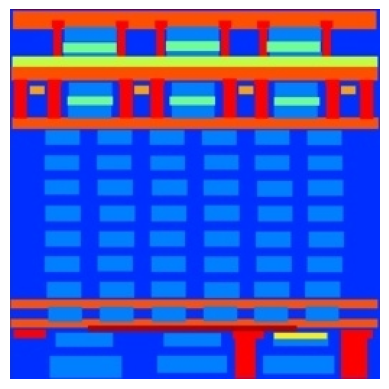

In [12]:
batch = next(iter(dataloader_train))

images  = batch["B"]
targets =  batch["A"]

img = images[0].cpu()
img = img * 0.5 + 0.5
np_img = img.permute(1, 2, 0).numpy()

plt.imshow(np_img)
plt.axis("off")
plt.show()

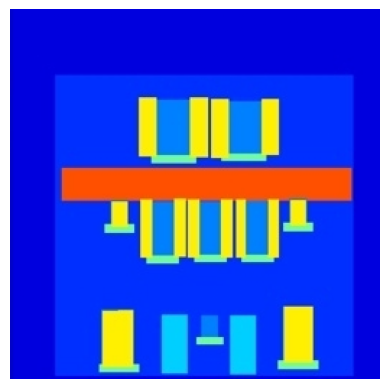

In [13]:
batch  = next(iter(dataloader_train))

# images are under batch["A"], targets under batch["B"]
images = batch["B"]    # shape: [batch_size, 3, 256, 256]
targets = batch["A"] # shape: [batch_size, 3, 256, 256]

# Now images[5] is a tensor, not a string
img_tensor = images[5].cpu()                     # [3, 256, 256]
img_denorm  = img_tensor * 0.5 + 0.5              # un-normalize from [-1,1] → [0,1]
np_img      = img_denorm.permute(1, 2, 0).numpy() # [256, 256, 3]

import matplotlib.pyplot as plt
plt.imshow(np_img)
plt.axis("off")
plt.show()

In [14]:
loss_GAN = nn.BCEWithLogitsLoss()
loss_L1 = nn.L1Loss()

In [15]:

def discriminator_training(batch, generator, discriminator, discriminator_opt, device):
    """
    Trains the discriminator on one batch.
    `batch` is a dict with keys "A" (inputs) and "B" (targets).
    Returns the discriminator loss.
    """
    discriminator_opt.zero_grad()

    real_A =  batch["B"].to(device)  # label maps
    real_B = batch["A"].to(device)  # real facades

    # --- Train on real pairs ---
    pred_real = discriminator(real_A, real_B)
    valid = torch.ones_like(pred_real).to(device)
    real_loss = loss_GAN(pred_real, valid)

    # --- Train on fake pairs ---
    with torch.no_grad():
        fake_B = generator(real_A)  # generated facades (no grad)
    pred_fake = discriminator(real_A, fake_B)
    fake = torch.zeros_like(pred_fake).to(device)
    fake_loss = loss_GAN(pred_fake, fake)

    # Total discriminator loss
    d_loss = 0.5 * (real_loss + fake_loss)
    d_loss.backward()
    discriminator_opt.step()

    return d_loss.detach()


In [16]:

def generator_training(batch, generator, discriminator, generator_opt, L1_lambda, device):
    """
    Trains the generator on one batch.
    Returns the generator loss and the generated images.
    """
    generator_opt.zero_grad()

    real_A = batch["B"].to(device)
    real_B = batch["A"].to(device)

    # Generate fake images
    fake_B = generator(real_A)

    # Adversarial loss (want discriminator to predict valid)
    pred_fake = discriminator(real_A, fake_B)
    valid = torch.ones_like(pred_fake).to(device)
    g_gan = loss_GAN(pred_fake, valid)

    # L1 loss between fake and real
    g_l1 = loss_L1(fake_B, real_B) * L1_lambda

    g_loss = g_gan + g_l1
    g_loss.backward()
    generator_opt.step()

    return g_loss.detach(), fake_B.detach()


In [17]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move models to device
generator     = generator.to(device)
discriminator = discriminator.to(device)

# Hyperparameters
lr       = 0.0002
beta1    = 0.5
beta2    = 0.999
L1_lambda = 100

# Optimizers
optimizer_G = optim.Adam(generator.parameters(),     lr=lr, betas=(beta1, beta2))
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr, betas=(beta1, beta2))


Epoch 1/20


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch 2/20


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch 3/20


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch 4/20


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch 5/20


  0%|          | 0/17 [00:00<?, ?it/s]

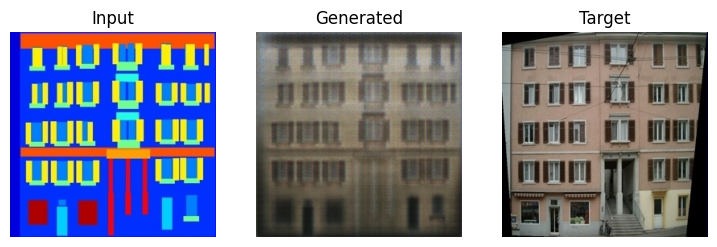

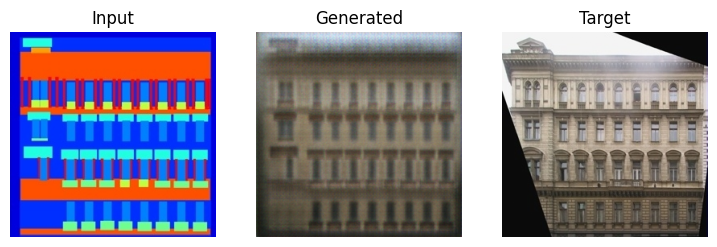

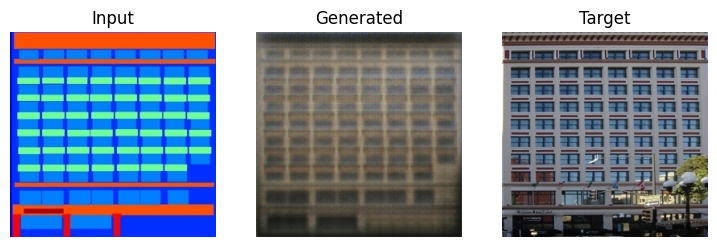

Epoch 6/20


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch 7/20


  0%|          | 0/17 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7b0a15a6cb80>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
    if w.is_alive():
       ^^^^^^Exception ignored in: ^^<function _MultiProcessingDataLoaderIter.__del__ at 0x7b0a15a6cb80>
^Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1618, in __del__
^^    ^
self._shutdown_workers()
  File "/usr/lib/python3.11/multiprocessing/process.py", line 160, in is_alive
      File "/usr/local/lib/python3.11/dist-packages/torch/utils/data/dataloader.py", line 1601, in _shutdown_workers
assert self._parent_pid == os.getpid(), 'can only test a child process'    
if w.is_alive(): 
            ^ ^^^ ^ ^ ^ ^^^^^^^^^^^
  File

Epoch 8/20


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch 9/20


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch 10/20


  0%|          | 0/17 [00:00<?, ?it/s]

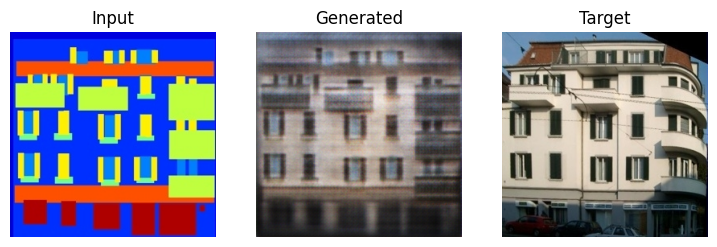

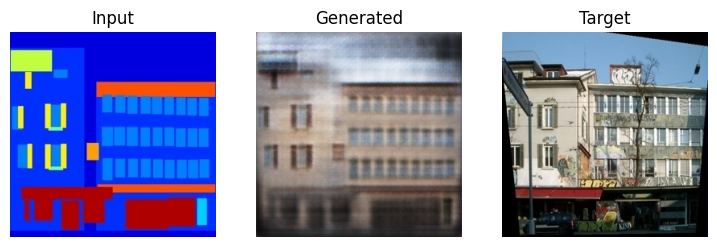

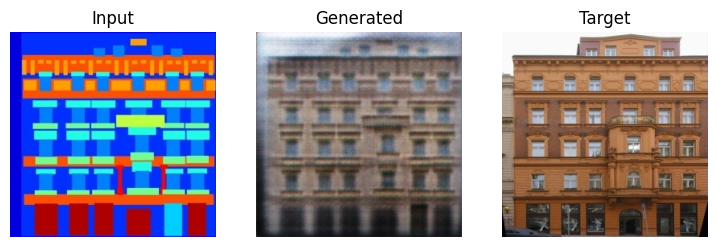

Epoch 11/20


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch 12/20


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch 13/20


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch 14/20


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch 15/20


  0%|          | 0/17 [00:00<?, ?it/s]

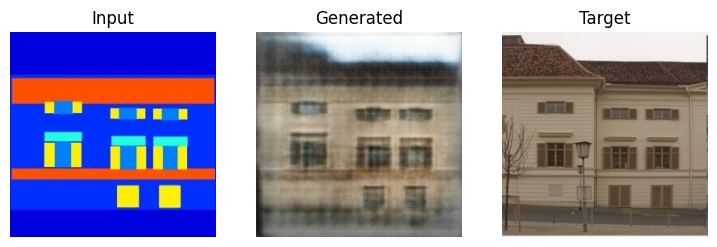

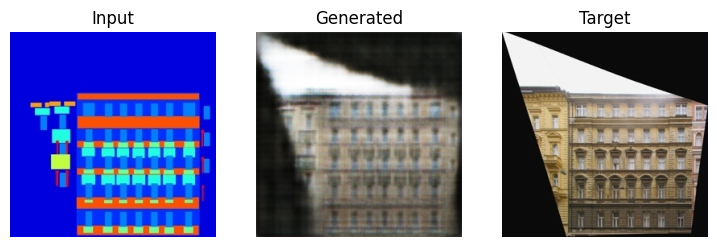

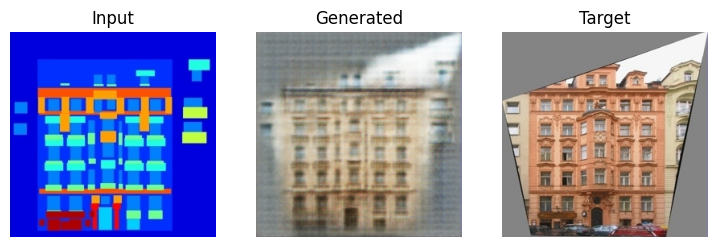

Epoch 16/20


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch 17/20


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch 18/20


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch 19/20


  0%|          | 0/17 [00:00<?, ?it/s]

Epoch 20/20


  0%|          | 0/17 [00:00<?, ?it/s]

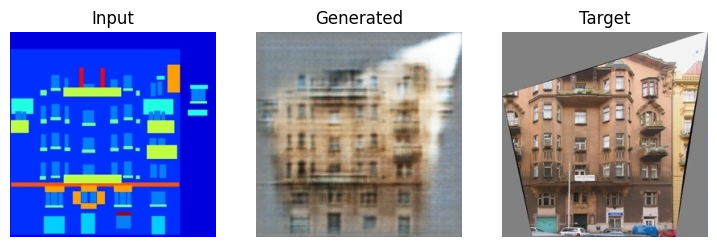

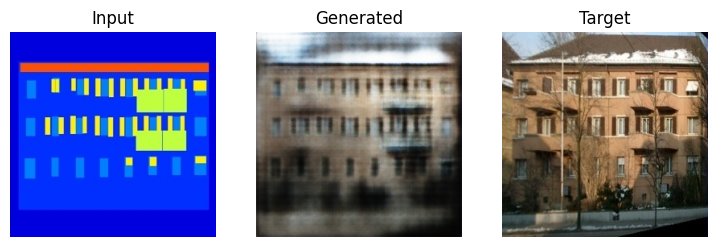

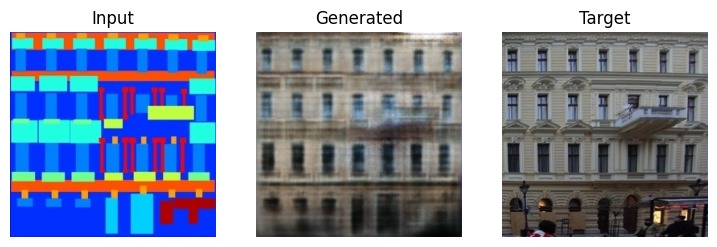

In [18]:

from tqdm.auto import tqdm

NUM_EPOCHS = 20

for epoch in range(1, NUM_EPOCHS + 1):
    print(f"Epoch {epoch}/{NUM_EPOCHS}")
    loop = tqdm(dataloader_train, leave=False)
    for batch in loop:
        # Train Discriminator
        d_loss = discriminator_training(
            batch, generator, discriminator, optimizer_D, device
        )

        # Train Generator (twice per discriminator update if desired)
        g_loss, gen_images = generator_training(
            batch, generator, discriminator, optimizer_G, L1_lambda, device
        )
        g_loss2, gen_images = generator_training(
            batch, generator, discriminator, optimizer_G, L1_lambda, device
        )

        loop.set_postfix({
            "D_loss": f"{d_loss.item():.4f}",
            "G_loss": f"{g_loss.item():.4f}"
        })

    # Every 5 epochs, visualize a few examples
    if epoch % 5 == 0:
        # Grab one batch from train set
        sample_batch = next(iter(dataloader_train))
        inputs  = sample_batch["B"].to(device)
        targets = sample_batch["A"].to(device)
        with torch.no_grad():
            outputs = generator(inputs)

        # De-normalize and plot first 3 images
        def denormalize(x):
            return x * 0.5 + 0.5  # assumes inputs in [-1,1]

        for i in range(3):
            plt.figure(figsize=(9, 3))
            img_in  = denormalize(inputs[i].cpu()).permute(1, 2, 0).numpy()
            img_gen = denormalize(outputs[i].cpu()).permute(1, 2, 0).numpy()
            img_real= denormalize(targets[i].cpu()).permute(1, 2, 0).numpy()
            plt.subplot(1, 3, 1); plt.imshow(img_in);  plt.title("Input");  plt.axis("off")
            plt.subplot(1, 3, 2); plt.imshow(img_gen); plt.title("Generated"); plt.axis("off")
            plt.subplot(1, 3, 3); plt.imshow(img_real);plt.title("Target");   plt.axis("off")
            plt.show()


In [24]:
MODEL_PATH = "/kaggle/working/gen_base.pth"  
torch.save(generator.state_dict(), MODEL_PATH)
print("✓ generator saved to", MODEL_PATH)


✓ generator saved to /kaggle/working/gen_base.pth


In [18]:
!pip install torchmetrics --quiet

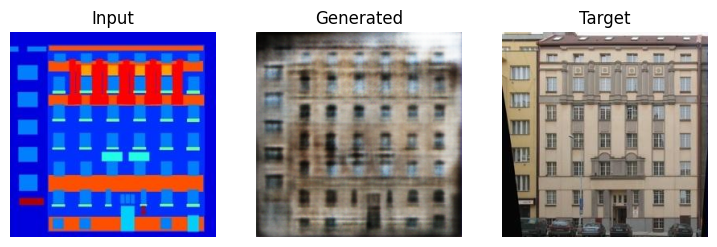

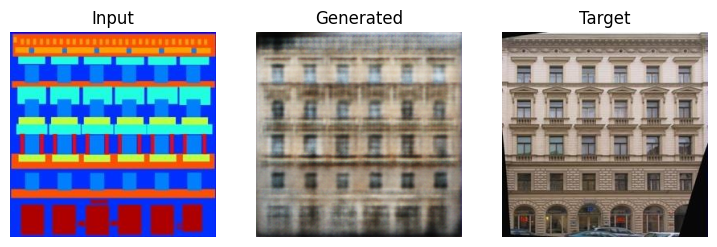

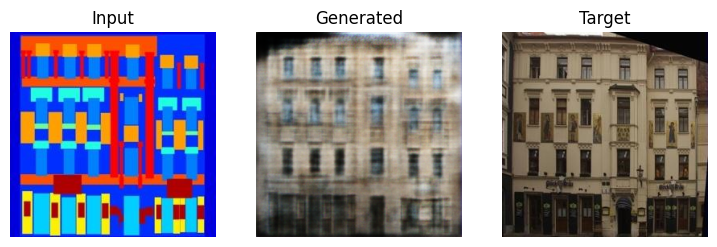

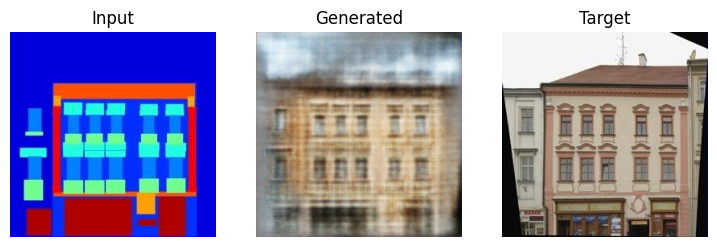

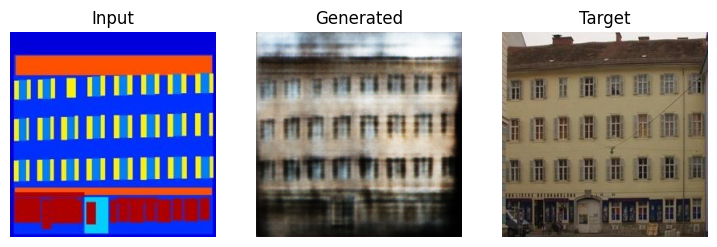

In [22]:
# ─── Cell 4: Testing on the Test Set ───────────────────────────────────────────

# Grab one batch from test set
sample_batch = next(iter(dataloader_test))
inputs  = sample_batch["B"].to(device)
targets = sample_batch["A"].to(device)

with torch.no_grad():
    outputs = generator(inputs)

# De-normalize and plot first 5 test images
def denormalize(x):
    return x * 0.5 + 0.5  # assumes inputs in [-1,1]

for i in range(5):
    plt.figure(figsize=(9, 3))
    img_in  = denormalize(inputs[i].cpu()).permute(1, 2, 0).numpy()
    img_gen = denormalize(outputs[i].cpu()).permute(1, 2, 0).numpy()
    img_real= denormalize(targets[i].cpu()).permute(1, 2, 0).numpy()
    plt.subplot(1, 3, 1); plt.imshow(img_in);  plt.title("Input");   plt.axis("off")
    plt.subplot(1, 3, 2); plt.imshow(img_gen); plt.title("Generated");plt.axis("off")
    plt.subplot(1, 3, 3); plt.imshow(img_real);plt.title("Target");   plt.axis("off")
    plt.show()


In [20]:

import torch
from torchmetrics.image.lpip  import LearnedPerceptualImagePatchSimilarity
from torchmetrics.image.ssim  import StructuralSimilarityIndexMeasure
from torchmetrics.regression.mae import MeanAbsoluteError        # pixel L1 / MAE

device = "cuda" if torch.cuda.is_available() else "cpu"

generator = Generator().to(device)
generator.load_state_dict(torch.load("/kaggle/input/pix2pixbase/other/default/1/gen_base.pth",
                                     map_location=device))
generator.eval()


def evaluate_small_set(generator, dataloader):
    lpips = LearnedPerceptualImagePatchSimilarity(net_type="vgg").to(device)
    ssim  = StructuralSimilarityIndexMeasure().to(device)
    mae   = MeanAbsoluteError().to(device)

    with torch.no_grad():
        for batch in dataloader:
            x = batch["B"].to(device)    # conditional input
            y = batch["A"].to(device)    # ground-truth target
            y_hat = generator(x)         # model output

            # scale to [0,1] float32 for perceptual + SSIM
            y_f      = (y     * 0.5 + 0.5).clamp(0, 1)
            y_hat_f  = (y_hat * 0.5 + 0.5).clamp(0, 1)

            lpips.update(y_hat_f, y_f)
            ssim.update(y_hat_f,  y_f)
            mae.update(y_hat,     y)     # MAE stays in [-1,1] scale

    return {
        "LPIPS" : lpips.compute().item(),   # lower = better
        "SSIM"  : ssim.compute().item(),    # higher = better
        "MAE"   : mae.compute().item()      # lower = better
    }

scores = evaluate_small_set(generator, dataloader_test)
print(scores)


Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 212MB/s] 


{'LPIPS': 0.5724446773529053, 'SSIM': 0.2550453245639801, 'MAE': 0.3788681626319885}
